In [2]:
import pandas as pd
df = pd.read_csv('sanitized.txt')
print(df.shape)
df.head()

(3701, 13)


,player,completions,passatt,passyards,passtds,ints,sacks,sackyards,rushatt,rushyards,rushtds,fumbles,season
0,Joe Flacco,24,35,251,1,0,2.0,14.0,4,7,0,1,2013
1,Ben Roethlisberger,28,44,257,2,0,0.0,0.0,1,11,0,0,2013
2,Tony Romo,23,32,225,1,0,2.0,17.0,1,-1,0,1,2013
3,Matthew Stafford,22,35,330,3,2,1.0,10.0,1,8,0,1,2013
4,Tom Brady,34,50,344,3,0,3.0,20.0,2,0,0,2,2013


In [3]:
df1 = df.copy()

# engineer some features

# why these features in particular?
# I was guided by the following concerns:
# - represent several different aspects of QB play
# - reduce dimensions to simplify the model

df1['netatt'] = df1['passatt'] + df1['sacks']
df1['touches'] = df1['netatt'] + df1['rushatt']
df1['net%'] = df1['completions'] / df1['netatt']
df1['netyards'] = df1['passyards'] - df1['sackyards']
df1['ny/a'] = df1['netyards'] / df1['netatt']
df1['ypc'] = df1['rushyards'] / df1['rushatt']
df1['tds'] = df1['passtds'] + df1['rushtds']
df1['tos'] = df1['ints'] + df1['fumbles']
df1['td:touch'] = df1['tds'] / df1['touches']
df1['to:touch'] = df1['tos'] / df1['touches']

# limit to our features
df1 = df1[['player', 'season', 'completions', 'passatt', 'passyards',
           'passtds', 'ints', 'sacks', 'sackyards', 'rushatt', 'rushyards',
           'rushtds', 'fumbles', 'touches', 'net%', 'ny/a', 'ypc', 'td:touch', 'to:touch']]

# fill NaN's introduced by our features
df1['net%'] = df1['net%'].fillna(0)
df1['ny/a'] = df1['ny/a'].fillna(0)
df1['ypc'] = df1['ypc'].fillna(0)

print(df1.shape)
df1.head()

(3701, 19)


,player,season,completions,passatt,passyards,passtds,ints,sacks,sackyards,rushatt,rushyards,rushtds,fumbles,touches,net%,ny/a,ypc,td:touch,to:touch
0,Joe Flacco,2013,24,35,251,1,0,2.0,14.0,4,7,0,1,41.0,0.648649,6.405405,1.75,0.024390,0.024390
1,Ben Roethlisberger,2013,28,44,257,2,0,0.0,0.0,1,11,0,0,45.0,0.636364,5.840909,11.00,0.044444,0.000000
2,Tony Romo,2013,23,32,225,1,0,2.0,17.0,1,-1,0,1,35.0,0.676471,6.117647,-1.00,0.028571,0.028571
3,Matthew Stafford,2013,22,35,330,3,2,1.0,10.0,1,8,0,1,37.0,0.611111,8.888889,8.00,0.081081,0.081081
4,Tom Brady,2013,34,50,344,3,0,3.0,20.0,2,0,0,2,55.0,0.641509,6.113208,0.00,0.054545,0.036364


In [4]:
df1.to_csv('data.txt', index=False)

In [5]:
# get league averages each year for each stat
stats = ['touches', 'net%', 'ny/a', 'ypc', 'td:touch', 'to:touch']
data = []
for y in df1['season'].unique():
    df = df1[df1['season'] == y]
    row = dict(year=y)
    for s in stats:
        row[f'{s}-mean'] = df[s].mean()
        row[f'{s}-std'] = df[s].std()
    data.append(row)

df2 = pd.DataFrame(data)
df2.head()

,year,touches-mean,touches-std,net%-mean,net%-std,ny/a-mean,ny/a-std,ypc-mean,ypc-std,td:touch-mean,td:touch-std,to:touch-mean,to:touch-std
0,2013,39.671141,10.716389,0.589464,0.106547,6.600505,2.044927,2.889356,4.089713,0.045448,0.033821,0.034888,0.032956
1,2009,35.856164,11.076113,0.584998,0.148305,6.607705,2.790235,2.408484,3.726143,0.047596,0.043012,0.034415,0.032109
2,2019,39.782609,11.570588,0.622188,0.108726,6.869714,2.071933,2.579043,3.354790,0.041730,0.036768,0.033036,0.033709
3,2007,35.005000,11.575619,0.602543,0.143763,6.628798,2.474819,2.285500,3.795700,0.052123,0.048801,0.027099,0.042884
4,2018,38.924623,10.659057,0.621171,0.104201,6.763276,2.117907,3.057536,3.925824,0.049852,0.036007,0.032029,0.073921


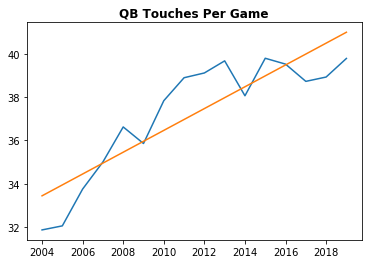

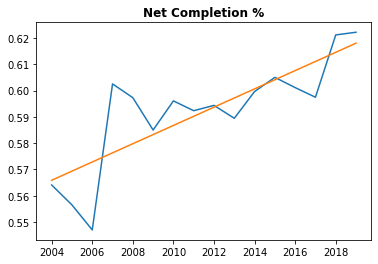

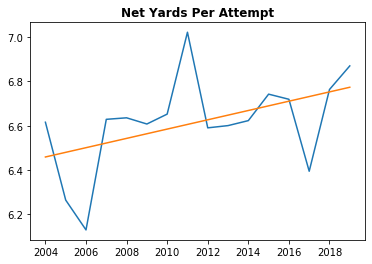

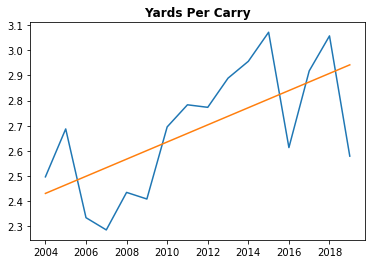

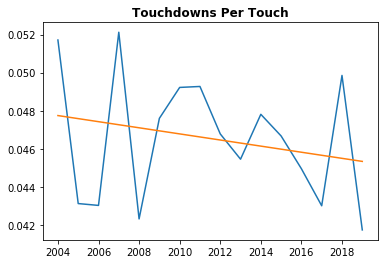

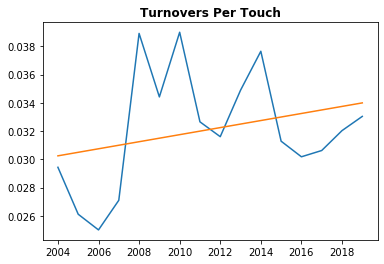

In [8]:
# why we need to adjust for year:
# there is a general trend of QBs getting
# better, even in this short window of time

import matplotlib.pyplot as plt
import numpy as np
df2 = df2.sort_values('year')

def demonstrate(x, y, stat):
    bf = np.poly1d(np.polyfit(x, y, 1))
    plt.plot(x, y)
    plt.plot(x, bf(x))
    plt.title(stat, fontweight='bold')
    plt.show()
    
def real_quick_now(col, tit):
    demonstrate(df2['year'], df2[f'{col}-mean'], tit)

real_quick_now('touches', 'QB Touches Per Game')
real_quick_now('net%', 'Net Completion %')
real_quick_now('ny/a', 'Net Yards Per Attempt')
real_quick_now('ypc', 'Yards Per Carry')
real_quick_now('td:touch', 'Touchdowns Per Touch')
real_quick_now('to:touch', 'Turnovers Per Touch')

In [7]:
df2.to_csv('years.txt', index=False)